# Detecting malicious URLs
Some introduction...

## Data exploration and cleaning

### General dataset information

In [95]:
DATASET_PATH = 'datasets/malicious_urls.csv'

In [96]:
import pandas as pd
import numpy as np

df = pd.read_csv(DATASET_PATH)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 651191 entries, 0 to 651190
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   url     651191 non-null  object
 1   type    651191 non-null  object
dtypes: object(2)
memory usage: 9.9+ MB


In [97]:
df.describe()

,url,type
count,651191,651191
unique,641119,4
top,http://style.org.hc360.com/css/detail/mysite/s...,benign
freq,180,428103


In [98]:
df.type.value_counts()

benign        428103
defacement     96457
phishing       94111
malware        32520
Name: type, dtype: int64

In [99]:
# Remove duplicates
df.drop_duplicates(inplace=True, subset=['url'], keep='last')
count = df.type.value_counts()
count

benign        428074
defacement     95308
phishing       94092
malware        23645
Name: type, dtype: int64

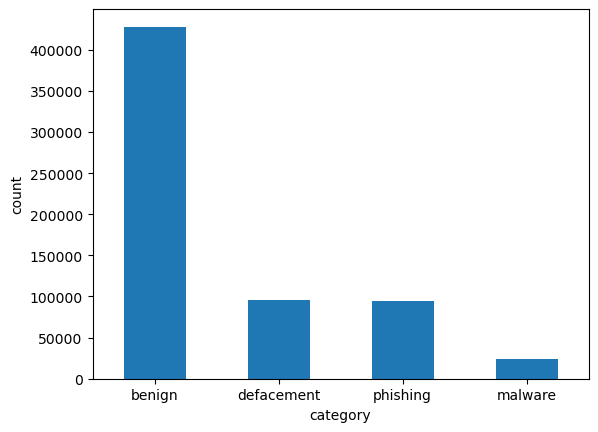

In [100]:
import matplotlib.pyplot as plt
count.plot.bar()
plt.xticks(rotation=0)
plt.xlabel("category")
plt.ylabel("count")
plt.show()

### Character encoding

In [101]:
# Detect character encoding
import chardet

encodings = df['url'].apply(lambda x: chardet.detect(str(x).encode('utf-8')))
df['encoding'] = encodings.apply(lambda x: x['encoding'])
df['enc_confidence'] = encodings.apply(lambda x: x['confidence'])

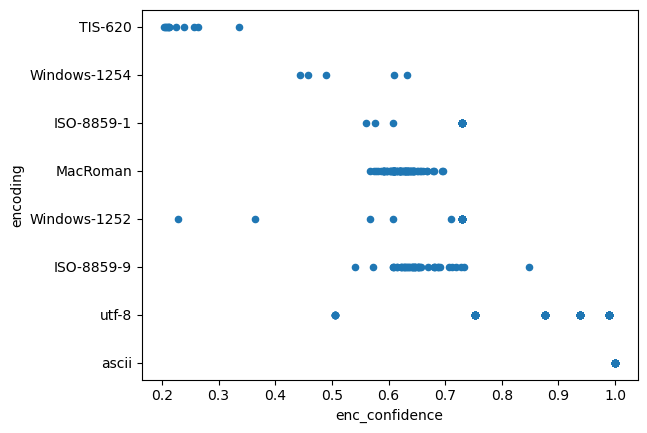

In [102]:
enc_df = pd.DataFrame(df[['encoding', 'enc_confidence']])
enc_df['encoding'] = enc_df['encoding'].apply(lambda x: str(x))
enc_df.drop(enc_df[enc_df.encoding == 'None'].index, inplace=True)
enc_df.plot.scatter(y = 'encoding', x = 'enc_confidence')
 
plt.show()

In [103]:
# By trying some queries we observe that there are some URL strings with broken encoding
df.query(expr='encoding not in ("ascii" , "utf-8")')

,url,type,encoding,enc_confidence
4491,citizendia.org/Agence_métropolitaine_de_transport,benign,ISO-8859-9,0.629187
7564,wn.com/HYMNE_NATIONAL_DU_QUÉBEC,benign,Windows-1252,0.730000
8116,forum.verygames.net/showthread.php?42812-Probl...,benign,MacRoman,0.635195
14053,dictionary.sensagent.com/jehane+benoît/fr-fr/,benign,ISO-8859-9,0.682751
14853,dictionary.sensagent.com/université+de+sherbro...,benign,MacRoman,0.621045
...,...,...,...,...
573492,ÆÖY'uEdS*Z£ñ>7ñV\pìnY÷¡ß¬á'×?...,phishing,TIS-620,0.210592
573495,ùAyéTôDpFc~h@^¶\øâèû¥ÊÞG·ê(Tøì\0«Y=D ...,phishing,None,0.000000
573499,=Rãmôj³{è!ÀM¶6<N>w ¼Cf£]4ÍnÝÌ,phishing,None,0.000000
573507,«Düéºþ +ZIdN Ö-lh9L©hDKÄúhßÆ%YqÃ±¹d,phishing,None,0.000000


In [104]:
# Attempt to fix some broken encoding
from ftfy import fix_encoding

df_fixed = pd.DataFrame()
df_fixed['url'] = df['url']
df_fixed['url_fixed'] = df_fixed['url'].apply(fix_encoding)
df_fixed.query(expr='url != url_fixed')

,url,url_fixed
44274,zoominfo.com/people/de%20GrandprÃ©_Jean_344774...,zoominfo.com/people/de%20Grandpré_Jean_3447745...
61961,http://www.scsrxx.com/js/?https://secure.runes...,http://www.scsrxx.com/js/?https://secure.runes...
126643,zoominfo.com/people/Sagan_FranÃƒÆ’Ã‚Â§oise_147...,zoominfo.com/people/Sagan_Françoise_1473040483...
300255,castroller.com/podcasts/CanaluPodcasts3/128646...,castroller.com/podcasts/CanaluPodcasts3/128646...
360359,zoominfo.com/people/SÃ©vigny_Danielle_15449882...,zoominfo.com/people/Sévigny_Danielle_154498825...
...,...,...
573506,r $ÐcYõ,r $Ðc˜‚Yõ
573507,«Düéºþ +ZIdN Ö-lh9L©hDKÄúhßÆ%YqÃ±¹d,«Dü‘éºþ +ZIdN Ö-lh9L©hŽDKÄúhßÆ%Yqñ¹d
573508,Þ~³\(ÿÇ½Jú$Xm £ÜëÃ5{¾kÜãCê_QÊ©B ÇÈc2...,އ~³„Ÿ\(ÿǽJú$Xm £ÜëÃ5{¾kÜãCê_QÊ©B…ǆÈc2#S...
573509,"ëËl×uÏB'JI¨GÙn""Ç( 0","ëËl×uÏB'JI¨GÙn""Ç(…0"


In [105]:
# Commit changes and check for strings that are still broken
df['url'] = df_fixed['url_fixed']
df.query('enc_confidence < 0.5')    # Includes all unidentified encodings

,url,type,encoding,enc_confidence
573417,esxcc.com/js/index.htm?us.battle.net/noghn/en/...,phishing,None,0.000000
573418,wwweira¯&nvinip¿ncH¯wVö%ÆåyDaHðû/ÏyEùuË\nÓ6...,phishing,None,0.000000
573422,ruta89fm.com/images/AS@Vies/1i75cf7b16vc<Fd16...,phishing,TIS-620,0.264226
573424,esxcc.com/js/index.htm?us.battle.net/login/en/...,phishing,Windows-1254,0.490066
573425,esxcc.com/js/index.htm?us.battle.net/login/en/...,phishing,Windows-1252,0.228806
573427,>Iq9E) l¬0™ZÝìÃw!'Ôp£ãW§&£Ñ p&$ImÞôöÝYÖ,phishing,TIS-620,0.257015
573429,esxcc.com/js/index.htm?us.battle.net/login/en/...,phishing,TIS-620,0.203882
573430,"˜ ꭛~l‡+×û¢ïÄÁŒR""+íI",phishing,None,0.000000
573431,ŠRybjUxÙãl5»7ÆE%ÝÔk+h |U+ýk©ìɔ½“Æq]âF·žõÁ...,phishing,None,0.000000
573432,§¬I0f9ÎPðÏ}åç`.7õú X '˜}—؁4~æʸa(_à,phishing,TIS-620,0.335509


In [106]:
# It seems there is an interval of rows where these invalid urls are concentrated
df.loc[573418:573510]

,url,type,encoding,enc_confidence
573418,wwweira¯&nvinip¿ncH¯wVö%ÆåyDaHðû/ÏyEùuË\nÓ6...,phishing,None,0.000000
573419,'www.institutocgr.coo/web/media/syqvem/dk-óij...,phishing,Windows-1252,0.730000
573420,Yìê‡ koãջΧDéÎl½ñ¡ââqtò¸/à; Í,phishing,utf-8,0.990000
573421,虠kvüDâQÎé4¼ÒŽ©,benign,utf-8,0.990000
573422,ruta89fm.com/images/AS@Vies/1i75cf7b16vc<Fd16...,phishing,TIS-620,0.264226
...,...,...,...,...
573506,r $Ðc˜‚Yõ,phishing,utf-8,0.990000
573507,«Dü‘éºþ +ZIdN Ö-lh9L©hŽDKÄúhßÆ%Yqñ¹d,phishing,None,0.000000
573508,އ~³„Ÿ\(ÿǽJú$Xm £ÜëÃ5{¾kÜãCê_QÊ©B…ǆÈc2#S...,phishing,None,0.000000
573509,"ëËl×uÏB'JI¨GÙn""Ç(…0",phishing,utf-8,0.990000


In [107]:
# Remove urls we can't fix
df.drop(df.loc[573418:573510].index, inplace=True)

In [108]:
# Remove enc_confidence as it will not be needed for training
df.drop('enc_confidence', axis=1, inplace=True)

### Prepare URLs for parsing

In [109]:
import re

# Add // before every URL so that urllib.parse can detect the netloc part correctly (https://docs.python.org/3/library/urllib.parse.html#urllib.parse.urlparse)
df['url'] = df['url'].apply(lambda x: '//' + str(x) if not re.match(pattern="^.{0,5}:\/\/", string=str(x)) else str(x))
df.head(10)

,url,type,encoding
0,//br-icloud.com.br,phishing,ascii
1,//mp3raid.com/music/krizz_kaliko.html,benign,ascii
2,//bopsecrets.org/rexroth/cr/1.htm,benign,ascii
3,http://www.garage-pirenne.be/index.php?option=...,defacement,ascii
4,http://adventure-nicaragua.net/index.php?optio...,defacement,ascii
5,http://buzzfil.net/m/show-art/ils-etaient-loin...,benign,ascii
6,//espn.go.com/nba/player/_/id/3457/brandon-rush,benign,ascii
7,//yourbittorrent.com/?q=anthony-hamilton-soulife,benign,ascii
8,http://www.pashminaonline.com/pure-pashminas,defacement,ascii
9,//allmusic.com/album/crazy-from-the-heat-r16990,benign,ascii


In [110]:
from urllib.parse import urlparse

# Check if we have any exceptions while parsing
success = True
for url in df['url']:
    try:
        urlparse(url)
    except ValueError as e:
        success = False
        print(e)
if success :
    print('no errors.')

no errors.


In [111]:
# Check again for duplicates since we changed some urls
df.drop_duplicates(inplace=True, subset=['url'], keep='last')

## Feature extraction

In [112]:
df['length'] = df['url'].apply(lambda x: len(str(x)))

urls = df['url'].apply(urlparse)

df['hostname'] = urls.apply(lambda x: x.hostname)
df['port'] = urls.apply(lambda x: x.port if x.port != '' else 0)
df['protocol'] = urls.apply(lambda x: x.scheme)
df['path'] = urls.apply(lambda x: x.path)
df['query'] = urls.apply(lambda x: x.query)
df['fragment'] = urls.apply(lambda x: x.fragment)

df.head(10)

,url,type,encoding,length,hostname,port,protocol,path,query,fragment
0,//br-icloud.com.br,phishing,ascii,18,br-icloud.com.br,NaN,,,,
1,//mp3raid.com/music/krizz_kaliko.html,benign,ascii,37,mp3raid.com,NaN,,/music/krizz_kaliko.html,,
2,//bopsecrets.org/rexroth/cr/1.htm,benign,ascii,33,bopsecrets.org,NaN,,/rexroth/cr/1.htm,,
3,http://www.garage-pirenne.be/index.php?option=...,defacement,ascii,88,www.garage-pirenne.be,NaN,http,/index.php,option=com_content&view=article&id=70&vsig70_0=15,
4,http://adventure-nicaragua.net/index.php?optio...,defacement,ascii,235,adventure-nicaragua.net,NaN,http,/index.php,option=com_mailto&tmpl=component&link=aHR0cDov...,
5,http://buzzfil.net/m/show-art/ils-etaient-loin...,benign,ascii,118,buzzfil.net,NaN,http,/m/show-art/ils-etaient-loin-de-s-imaginer-que...,,
6,//espn.go.com/nba/player/_/id/3457/brandon-rush,benign,ascii,47,espn.go.com,NaN,,/nba/player/_/id/3457/brandon-rush,,
7,//yourbittorrent.com/?q=anthony-hamilton-soulife,benign,ascii,48,yourbittorrent.com,NaN,,/,q=anthony-hamilton-soulife,
8,http://www.pashminaonline.com/pure-pashminas,defacement,ascii,44,www.pashminaonline.com,NaN,http,/pure-pashminas,,
9,//allmusic.com/album/crazy-from-the-heat-r16990,benign,ascii,47,allmusic.com,NaN,,/album/crazy-from-the-heat-r16990,,


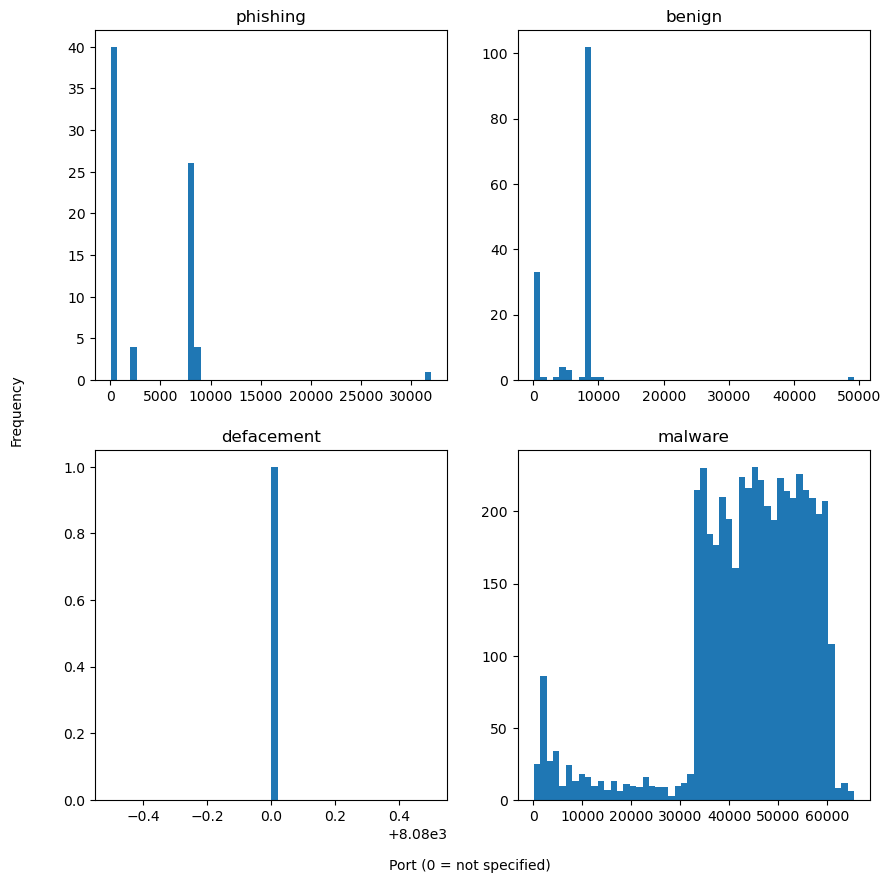

In [113]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

types = df['type'].unique()
for i, t in enumerate(types):
    row = i // 2
    col = i % 2
    ax = axs[row, col]
    ax.hist(df.loc[df['type'] == t, 'port'], bins=50)
    ax.set_title(t)

fig.text(0.5, 0.04, 'Port (0 = not specified)', ha='center')
fig.text(0.04, 0.5, 'Frequency', va='center', rotation='vertical')

plt.show()

In [114]:
from urllib.parse import parse_qs

df['query_length'] = df['query'].apply(lambda x: len(str(x)))

df['query_args'] = df['query'].apply(lambda x: len(parse_qs(x)))

In [115]:
from pathlib import Path

df['path_length'] = df['path'].apply(lambda x: len(str(x)))

df['path_depth'] = df['path'].apply(lambda x: len(Path(str(x)).parents))

In [116]:
import ipaddress
import tldextract as tldx

def is_ip(url):
    try:
        ip = ipaddress.ip_address(url)
    except:
        return False
    return str(ip) == url

def count_subdomains(hostname, has_ip):
    if has_ip:
        return 0
    else:
        ext = tldx.extract(hostname)
        return len(ext.subdomain.split('.'))

def extract_tld(hostname, has_ip):
    if has_ip:
        return ''
    else:
        ext = tldx.extract(hostname)
        return ext.suffix
    

df['hostname_length'] = df['hostname'].apply(lambda x: len(str(x)))
df['has_ip'] = df['hostname'].apply(lambda x: 1 if is_ip(str(x)) else 0)
df['num_subdomains'] = df.apply(lambda row: count_subdomains(row['hostname'], row['has_ip']), axis=1)
df['tld'] = df.apply(lambda row: extract_tld(row['hostname'], row['has_ip']), axis=1)

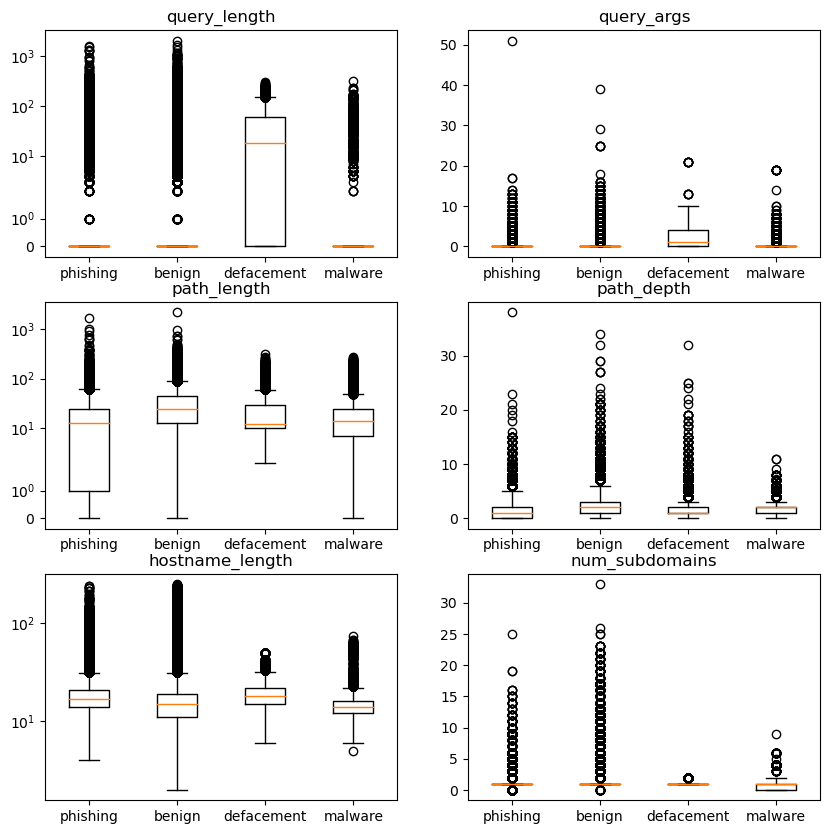

In [117]:
features = ['query_length', 'query_args', 'path_length', 'path_depth', 'hostname_length', 'num_subdomains']

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(10, 10))

for i, feature in enumerate(features):
    row = i // 2
    col = i % 2
    ax = axs[row, col]
    ax.boxplot([df[df['type'] == t][feature] for t in df['type'].unique()])
    ax.set_title(feature)
    ax.set_xticklabels(df['type'].unique())
    if(feature in ['query_length', 'path_length', 'hostname_length']):
        ax.set_yscale('symlog')

plt.show()

In [118]:
df['has_urlencoded_char'] = df['url'].apply(lambda x: 1 if '%' in str(x) else 0)
df['is_abnormal_url'] = df['protocol'].apply(lambda x: 1 if str(x) == '' else 0)
df['has_fragment'] = df['fragment'].apply(lambda x: 1 if str(x) != '' else 0)

In [126]:
# Match URL shorteners
SHORTENERS = 'datasets/shorteners.txt'

with open(SHORTENERS, 'r') as f:
    shorteners = [line.strip() for line in f.readlines()]

df['is_shortener'] = df['hostname'].apply(lambda x: 1 if x in shorteners else 0)

df.query('is_shortener == 1')['url'].count()

1112

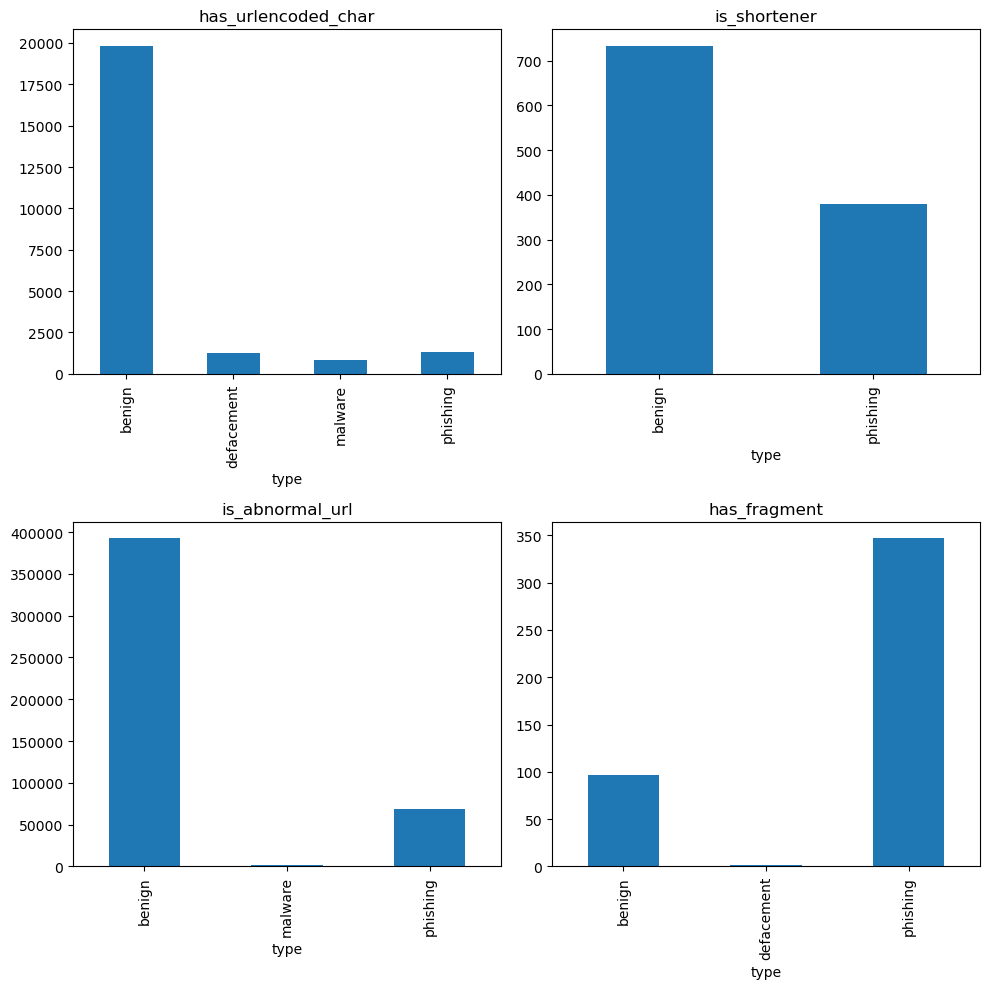

In [120]:
features = ['has_urlencoded_char', 'is_shortener', 'is_abnormal_url', 'has_fragment']

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
for i, feature in enumerate(features):
    row = i // 2
    col = i % 2
    ax = axes[row, col]
    df[df[feature] == True].groupby('type')[feature].count().plot.bar(ax=ax)
    ax.set_title(feature)

plt.tight_layout()
plt.show()

<Axes: >

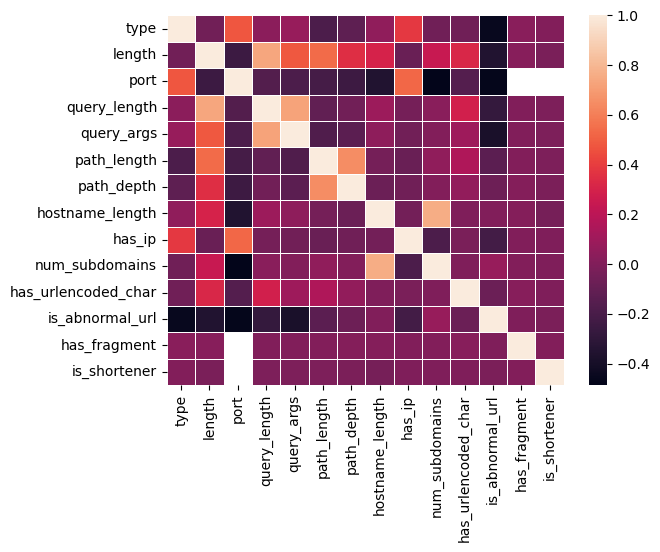

In [121]:
import seaborn as sns

plt.figure()
temp_df = pd.DataFrame(df)
temp_df['type'] = temp_df['type'].apply(lambda x: 1 if x == 'defacement' else 2 if x == 'phishing' else 3 if x == 'malware' else 0)
sns.heatmap(temp_df.corr(numeric_only=True), linewidths=.5)

## Training set

In [122]:
train_Y = df['type']
train_x_raw = df.drop(['url', 'type', 'hostname', 'path', 'query', 'fragment'], axis=1)

train_x_raw.describe(include='all')

,encoding,length,port,protocol,query_length,query_args,path_length,path_depth,hostname_length,has_ip,num_subdomains,tld,has_urlencoded_char,is_abnormal_url,has_fragment,is_shortener
count,641013,641014.000000,5141.000000,641014,641014.000000,641014.000000,641014.000000,641014.000000,641014.000000,641014.000000,641014.000000,641014,641014.000000,641014.000000,641014.000000,641014.000000
unique,7,NaN,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,886,NaN,NaN,NaN,NaN
top,ascii,NaN,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,com,NaN,NaN,NaN,NaN
freq,640203,NaN,NaN,463070,NaN,NaN,NaN,NaN,NaN,NaN,NaN,393890,NaN,NaN,NaN,NaN
mean,NaN,61.200038,42396.719510,NaN,11.572874,0.544636,28.513716,2.074264,17.405997,0.018917,1.086831,NaN,0.036294,0.722402,0.000694,0.001735
std,NaN,44.552114,14914.113409,NaN,34.030121,1.361899,27.937355,1.593860,11.351191,0.136232,0.818694,NaN,0.187021,0.447814,0.026339,0.041614
min,NaN,7.000000,70.000000,NaN,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,0.000000
25%,NaN,33.000000,36851.000000,NaN,0.000000,0.000000,10.000000,1.000000,12.000000,0.000000,1.000000,NaN,0.000000,0.000000,0.000000,0.000000
50%,NaN,48.000000,45211.000000,NaN,0.000000,0.000000,21.000000,2.000000,16.000000,0.000000,1.000000,NaN,0.000000,1.000000,0.000000,0.000000
75%,NaN,78.000000,53106.000000,NaN,0.000000,0.000000,39.000000,3.000000,20.000000,0.000000,1.000000,NaN,0.000000,1.000000,0.000000,0.000000


In [123]:
col_names = np.array(train_x_raw.columns)

nominal_idx = [np.where(col_names == 'encoding')[0][0], np.where(col_names == 'tld')[0][0], np.where(col_names == 'protocol')[0][0]]
binary_idx = [np.where(col_names == 'has_ip')[0][0], np.where(col_names == 'has_urlencoded_char')[0][0], np.where(col_names == 'is_shortener')[0][0], np.where(col_names == 'is_abnormal_url')[0][0], np.where(col_names == 'has_fragment')[0][0]]
numeric_idx = list(set(range(len(col_names))).difference(nominal_idx).difference(binary_idx))

nominal_cols = col_names[nominal_idx].tolist()
binary_cols = col_names[binary_idx].tolist()
numeric_cols = col_names[numeric_idx].tolist()

print(numeric_cols)
print(binary_cols)
print(nominal_cols)

train_x_raw[binary_cols].describe().transpose()

['length', 'port', 'query_length', 'query_args', 'path_length', 'path_depth', 'hostname_length', 'num_subdomains']
['has_ip', 'has_urlencoded_char', 'is_shortener', 'is_abnormal_url', 'has_fragment']
['encoding', 'tld', 'protocol']


,count,mean,std,min,25%,50%,75%,max
has_ip,641014.0,0.018917,0.136232,0.0,0.0,0.0,0.0,1.0
has_urlencoded_char,641014.0,0.036294,0.187021,0.0,0.0,0.0,0.0,1.0
is_shortener,641014.0,0.001735,0.041614,0.0,0.0,0.0,0.0,1.0
is_abnormal_url,641014.0,0.722402,0.447814,0.0,0.0,1.0,1.0,1.0
has_fragment,641014.0,0.000694,0.026339,0.0,0.0,0.0,0.0,1.0


In [124]:
train_x = pd.get_dummies(train_x_raw, columns=nominal_cols, drop_first=True)
dummy_variables = list(set(train_x)-set(train_x_raw))
train_x.describe()

,length,port,query_length,query_args,path_length,path_depth,hostname_length,has_ip,num_subdomains,has_urlencoded_char,...,tld_xxx,tld_xyz,tld_yk.ca,tld_yt,tld_zj.cn,tld_zone,tld_zp.ua,protocol_ftp,protocol_http,protocol_https
count,641014.000000,5141.000000,641014.000000,641014.000000,641014.000000,641014.000000,641014.000000,641014.000000,641014.000000,641014.000000,...,641014.000000,641014.000000,641014.000000,641014.000000,641014.000000,641014.000000,641014.000000,641014.000000,641014.000000,641014.000000
mean,61.200038,42396.719510,11.572874,0.544636,28.513716,2.074264,17.405997,0.018917,1.086831,0.036294,...,0.000002,0.000755,0.000002,0.000003,0.000002,0.000005,0.000002,0.000003,0.253200,0.024394
std,44.552114,14914.113409,34.030121,1.361899,27.937355,1.593860,11.351191,0.136232,0.818694,0.187021,...,0.001249,0.027468,0.001249,0.001766,0.001249,0.002163,0.001249,0.001766,0.434845,0.154270
min,7.000000,70.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,33.000000,36851.000000,0.000000,0.000000,10.000000,1.000000,12.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,48.000000,45211.000000,0.000000,0.000000,21.000000,2.000000,16.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,78.000000,53106.000000,0.000000,0.000000,39.000000,3.000000,20.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,2177.000000,65509.000000,2005.000000,51.000000,2156.000000,38.000000,248.000000,1.000000,33.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [125]:
# Normalize features
from sklearn.preprocessing import StandardScaler

# RobustScaler could also be used, but query_length would have mean = 11 and std = 34. Is it statistically accceptable?
robust_scaler = StandardScaler().fit(train_x[numeric_cols])
train_x[numeric_cols] = robust_scaler.transform(train_x[numeric_cols])

train_x[numeric_cols].describe()

,length,port,query_length,query_args,path_length,path_depth,hostname_length,num_subdomains
count,6.410140e+05,5.141000e+03,6.410140e+05,6.410140e+05,6.410140e+05,6.410140e+05,6.410140e+05,6.410140e+05
mean,5.320641e-19,-1.142832e-16,-5.107815e-17,-2.216934e-17,2.660320e-19,8.796793e-17,-4.218825e-17,2.724611e-17
std,1.000001e+00,1.000097e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00
min,-1.216555e+00,-2.838307e+00,-3.400776e-01,-3.999093e-01,-1.020631e+00,-1.301410e+00,-1.357215e+00,-1.327520e+00
25%,-6.329679e-01,-3.718799e-01,-3.400776e-01,-3.999093e-01,-6.626873e-01,-6.740018e-01,-4.762497e-01,-1.060607e-01
50%,-2.962833e-01,1.887175e-01,-3.400776e-01,-3.999093e-01,-2.689489e-01,-4.659358e-02,-1.238635e-01,-1.060607e-01
75%,3.770859e-01,7.181333e-01,-3.400776e-01,-3.999093e-01,3.753502e-01,5.808146e-01,2.285227e-01,-1.060607e-01
max,4.749049e+01,1.549843e+00,5.857836e+01,3.704784e+01,7.615209e+01,2.254010e+01,2.031454e+01,3.898063e+01


## TODO

- optional: WHOIS query
- optional: Try to detect XSS/SQL/code injection

### Didn't do

- Detect base 64/hex (too hard)
- Detect homographs (didn't find any in the dataset)
- Detect "spoofed" hostnames in other parts of the URL (hard to match, found only one)
- Match specific words (admin, login, password...) OR do stemming